# Factor Analysis and Factor Currency Conversion

### Common Imports

In [ ]:
! pip install forex-python

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

sns.set() #to plot nice graphs

from google.colab import files #to upload csv in colab
uploaded = files.upload()  

### import and curation

In [ ]:
import io
df = pd.read_excel(io.BytesIO(uploaded['SX5E.xlsx']))
df.rename(str.lower, axis='columns', inplace=True) #set all column names to lowercase
df.dates = pd.to_datetime(df["dates"], '%y-%m-%d') #convert the dates from strings to datetime format

#we keep only the monthly observations

n_month=[]
year=[]
for x in df["dates"]:
  n_month.append(x.month)
  year.append(x.year)
df["n_month"]=n_month
df["year"]=year
 
g=df.groupby(["year", "n_month"])
df=g.tail(1).reset_index(drop=True)

# and compute the return

df["return"]=df["px_last"].pct_change()

df.rename(columns={"dates":"date"}, inplace=True)
df["date"]=df["date"].apply(lambda x: x.strftime('%Y-%m'))
df["date"]=df["date"].astype(str)
df.head()

,date,px_last,n_month,year,return
0,2010-09,2747.90,9,2010,NaN
1,2010-10,2844.99,10,2010,0.035332
2,2010-11,2650.99,11,2010,-0.068190
3,2010-12,2792.82,12,2010,0.053501
4,2011-01,2953.63,1,2011,0.057580


In [ ]:
ff5f_eu = pd.read_csv(io.BytesIO(uploaded['Europe_5_Factors.csv']), skiprows=3, header=0, engine='python', skipfooter=34)

ff5f_eu.rename(str.lower, axis='columns', inplace=True) #set all column names to lowercase
ff5f_eu.rename(columns={"unnamed: 0":"date"}, inplace=True)

ff5f_eu["date"]=ff5f_eu["date"].apply(str)
ff5f_eu["date"]=ff5f_eu["date"].str.strip()
new_dates=[]  #create a new (empty) list
for date in ff5f_eu["date"]: #for each date
  new_date=dt.strptime(date,'%Y%m').strftime('%Y-%m') #trasform it
  new_dates.append(new_date) # and append it to the empty list of new dates
ff5f_eu["date"]=new_dates

ff5f_eu.reset_index(inplace=True) # resetting the index for usability reasons 
ff5f_eu.drop("index", axis=1, inplace=True)

ff5f_eu.head()

,date,mkt-rf,smb,hml,rmw,cma,rf
0,1990-07,4.46,0.20,-1.52,0.28,1.10,0.68
1,1990-08,-10.88,0.25,-0.30,-0.50,1.66,0.66
2,1990-09,-12.19,1.92,0.44,0.33,1.78,0.60
3,1990-10,6.45,-2.58,-1.12,0.86,-0.73,0.68
4,1990-11,-0.42,-2.66,0.57,0.25,-0.33,0.57


In [ ]:
import io
mom_eu = pd.read_csv(io.BytesIO(uploaded['Europe_MOM_Factor EU.csv']), skiprows=4, header=0, names=['date','mom'])
mom_eu['date']=mom_eu['date'].str.strip()
mom_eu=mom_eu.iloc[0:356]

mom_eu["date"]=mom_eu["date"].apply(str)
new_dates=[]  #create a new (empty) list
for date in mom_eu["date"]: #for each date
  new_date=dt.strptime(date,'%Y%m').strftime('%Y-%m') #transform it
  new_dates.append(new_date) # and append it to the empty list of new dates
mom_eu["date"]=new_dates

mom_eu=mom_eu.iloc[122:356]

mom_eu=mom_eu.reset_index().iloc[:, 1:]

mom_eu.head()

,date,mom
0,2001-01,-6.64
1,2001-02,7.67
2,2001-03,4.03
3,2001-04,-4.19
4,2001-05,6.69


In [ ]:
final_eu = pd.merge(pd.merge(df,ff5f_eu, on="date"), mom_eu, on="date")
final_eu = final_eu.sort_values(by = "date")
final_eu.head()

,date,px_last,n_month,year,return,mkt-rf,smb,hml,rmw,cma,rf,mom
0,2010-09,2747.90,9,2010,NaN,11.56,0.93,-0.28,-0.43,1.55,0.01,4.35
1,2010-10,2844.99,10,2010,0.035332,4.98,0.62,0.08,1.38,-0.33,0.01,0.19
2,2010-11,2650.99,11,2010,-0.068190,-8.03,1.07,-3.46,1.77,0.11,0.01,7.91
3,2010-12,2792.82,12,2010,0.053501,9.04,2.18,1.11,-1.60,1.12,0.01,1.86
4,2011-01,2953.63,1,2011,0.057580,3.68,-0.22,5.52,-3.02,1.37,0.01,-5.51


### Currency Conversion

In [ ]:
from forex_python.converter import get_rate
  
rates =[]  #create a new (empty) list
for date in final_eu['date']: #for each date
  year=int(dt.strptime(str(date),'%Y-%m').strftime('%Y'))
  month=int(dt.strptime(str(date),'%Y-%m').strftime('%m'))
  num_days = calendar.monthrange(year, month) #get days
  day=num_days[-1]
  
  t = dt(year, month, day)
  rate = get_rate("USD", "EUR", t)
  rates.append(rate) # create a list of the days in each month
final_eu['exchange rate']=rates

#The exchange rate return is calculated by dividing the spot exchange rates 
#of two consecutive observation periods less one.
final_eu['exchange rate'] = final_eu['exchange rate'].pct_change(1)


final_eu['smb'] = final_eu['smb']* (1/(1+final_eu['exchange rate']))
final_eu['hml'] = final_eu['hml']* (1/(1+final_eu['exchange rate']))
final_eu['mom'] = final_eu['mom'].astype(float)* (1/(1+final_eu['exchange rate']))
final_eu["rmw"] = final_eu['rmw'].astype(float)* (1/(1+final_eu['exchange rate']))	
final_eu["cma"] = final_eu['cma'].astype(float)* (1/(1+final_eu['exchange rate']))


final_eu['mom'] = final_eu['mom'].astype(float)
final_eu["rmw"] = final_eu['rmw'].astype(float)	
final_eu["cma"] = final_eu['cma'].astype(float)

EURIBOR = pd.read_excel(io.BytesIO(uploaded['3 Month EURIBOR.xlsx']), skiprows = 16, header = 0, usecols = 'A:B')
EURIBOR.rename(columns={"Exchange Date":"date", "Bid":"euribor"}, inplace=True)
EURIBOR['date'] = pd.to_datetime(EURIBOR['date'], format='%Y/%m/%d').dt.strftime('%Y-%m')
EURIBOR = EURIBOR.sort_values(by = 'date')

final_eu = pd.merge(final_eu,EURIBOR, on="date", how='inner')
final_eu = final_eu.sort_values(by = 'date')
final_eu['mkt-rf'] = (1 + final_eu['mkt-rf'] + final_eu['rf']) * (1/(1+final_eu['exchange rate'])) - 1 - final_eu['euribor']
final_eu["return"]=final_eu["return"]*100
final_eu["excess_return"] = final_eu["return"] - final_eu["euribor"]
final_eu.head()

,date,px_last,n_month,year,return,mkt-rf,smb,hml,rmw,cma,rf,mom,exchange rate,euribor,excess_return
0,2010-09,2747.90,9,2010,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN,0.892,NaN
1,2010-10,2844.99,10,2010,3.533244,4.036728,0.629494,0.081225,1.401133,-0.335053,0.01,0.192910,-0.015083,1.045,2.488244
2,2010-11,2650.99,11,2010,-6.819005,-8.612828,1.003670,-3.245513,1.660277,0.103181,0.01,7.419656,0.066087,1.028,-7.847005
3,2010-12,2792.82,12,2010,5.350077,8.325443,2.241049,1.141085,-1.644807,1.151365,0.01,1.912088,-0.027241,1.006,4.344077
4,2011-01,2953.63,1,2011,5.757979,2.731828,-0.225433,5.656327,-3.094585,1.403835,0.01,-5.646080,-0.024102,1.074,4.683979


### Factor Models

In [ ]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.summary2 import summary_col

In [ ]:
class Factor_Analysis:

  def df_factor(self, df):
    df_data = df.loc[:, ["date","excess_return","mkt-rf","smb","hml","rmw","cma","mom"]].copy()
    return df_data.iloc[1:,:]


  def __init__(self, df):
    self.df_rf= self.df_factor(df)

In [ ]:
 class regression_models:

    def regression_model(self, df):
    
      Y=df.iloc[: , 1]

      X=df[["mkt-rf"]]
      X=sm.add_constant(X)
      model1 = sm.OLS(Y, X, hasconst=True)
      res1 = model1.fit()

      X=df[["mkt-rf","smb","hml","mom"]]
      X=sm.add_constant(X)
      model2 = sm.OLS(Y, X, hasconst=True)
      res2 = model2.fit()

      X=df[["mkt-rf","smb","hml","rmw","mom"]]
      X=sm.add_constant(X)
      model3 = sm.OLS(Y, X, hasconst=True)
      res3 = model3.fit()

      X=df[["mkt-rf","smb","hml","rmw","cma","mom"]]
      X=sm.add_constant(X)
      model4 = sm.OLS(Y, X, hasconst=True)
      res4 = model4.fit()
    
      print()
      print()
      Y.output = summary_col([res1,res2,res3,res4], stars=True,
                    regressor_order=["const","mkt-rf","mom","smb","hml","rmw","cma"],
                    model_names=['Model\n(1)', 'Model\n(2)', 'Model\n(3)',  'Model\n(4)'],
                    info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'R2':lambda x: "{:.4f}".format(x.rsquared)})
      return (Y.output)
  
    def params(self, df):
      Y=df.iloc[: , 1]

      X=df[["mkt-rf"]]
      X=sm.add_constant(X)
      model1 = sm.OLS(Y, X, hasconst=True)
      res1 = model1.fit()
      par1=res1.params
      p1=res1.pvalues

      X=df[["mkt-rf","smb","hml","mom"]]
      X=sm.add_constant(X)
      model2 = sm.OLS(Y, X, hasconst=True)
      res2 = model2.fit()
      par2=res2.params
      p2=res2.pvalues

      X=df[["mkt-rf","smb","hml","rmw","mom"]]
      X=sm.add_constant(X)
      model3 = sm.OLS(Y, X, hasconst=True)
      res3 = model3.fit()
      par3=res3.params
      p3=res3.pvalues

      X=df[["mkt-rf","smb","hml","rmw","cma","mom"]]
      X=sm.add_constant(X)
      model4 = sm.OLS(Y, X, hasconst=True)
      res4 = model4.fit()
      par4=res4.params
      p4=res4.pvalues

      index_tab=["model_1","p_val1","model_2","p_val2", "model_3", "p_val3", "model_4", "p_val4"]
      parameters=pd.DataFrame([par1, p1, par2, p2, par3, p3, par4, p4], index=index_tab)
      
      return parameters


    def __init__(self, df):
      self.regression=self.regression_model(df)
      self.params=self.params(df)

In [ ]:
def yearly(df, years):
  m=years*12
  df=pd.DataFrame(df)
  i=0
  yearly_data=pd.DataFrame(columns=["const","mkt-rf","smb","hml","mom","rmw","cma"])
  while i <= len(df):
    if i+(m-1) <= len(df):
      ds=df.iloc[i:i+m, :]

      Y=ds.iloc[: , 1]

      X=ds[["mkt-rf"]]
      X=sm.add_constant(X)
      model1 = sm.OLS(Y, X.astype(float), hasconst=True)
      res1 = model1.fit()
      par1=res1.params
      p1=res1.pvalues

      X=ds[["mkt-rf","smb","hml","mom"]]
      X=sm.add_constant(X)
      model2 = sm.OLS(Y, X.astype(float), hasconst=True)
      res2 = model2.fit()
      par2=res2.params
      p2=res2.pvalues

      X=ds[["mkt-rf","smb","hml","rmw","mom"]]
      X=sm.add_constant(X)
      model3 = sm.OLS(Y, X.astype(float), hasconst=True)
      res3 = model3.fit()
      par3=res3.params
      p3=res3.pvalues

      X=ds[["mkt-rf","smb","hml","rmw","cma","mom"]]
      X=sm.add_constant(X)
      model4 = sm.OLS(Y, X.astype(float), hasconst=True)
      res4 = model4.fit()
      par4=res4.params
      p4=res4.pvalues

      index_tab=[list(zip(np.repeat(df.date.iloc[i],8), np.repeat(df.date.iloc[i+m-1], 8))),
                 np.array(["model_1","p_val1","model_2","p_val2", "model_3", "p_val3", "model_4", "p_val4"])]
      parameters=pd.DataFrame([par1, p1, par2, p2, par3, p3, par4, p4], index=index_tab)
      yearly_data=pd.concat([yearly_data,parameters])
          
         
      i+=12
    
    else:
      ds=df.iloc[i: , :]

      Y=ds.iloc[: , 1]

      X=ds[["mkt-rf"]]
      X=sm.add_constant(X)
      model1 = sm.OLS(Y, X.astype(float), hasconst=True)
      res1 = model1.fit()
      par1=res1.params
      p1=res1.pvalues

      X=ds[["mkt-rf","smb","hml","mom"]]
      X=sm.add_constant(X)
      model2 = sm.OLS(Y, X.astype(float), hasconst=True)
      res2 = model2.fit()
      par2=res2.params
      p2=res2.pvalues

      X=ds[["mkt-rf","smb","hml","rmw","mom"]]
      X=sm.add_constant(X)
      model3 = sm.OLS(Y, X.astype(float), hasconst=True)
      res3 = model3.fit()
      par3=res3.params
      p3=res3.pvalues

      X=ds[["mkt-rf","smb","hml","rmw","cma","mom"]]
      X=sm.add_constant(X)
      model4 = sm.OLS(Y, X.astype(float), hasconst=True)
      res4 = model4.fit()
      par4=res4.params
      p4=res4.pvalues

      index_tab= [list(zip(np.repeat(df.date.iloc[i],8),np.repeat(df.date.iloc[-1],8))),
                  np.array(["model_1","p_val1","model_2","p_val2", "model_3", "p_val3", "model_4", "p_val4"])]
      parameters=pd.DataFrame([par1, p1, par2, p2, par3, p3, par4, p4], index=index_tab)
      results=pd.concat([yearly_data,parameters])
      index = pd.MultiIndex.from_tuples(results.index)
      results.set_index(index, inplace=True)
      
      return results
          
      break

In [ ]:
def plot_models(df, model):
  sns.set_style("whitegrid")
  ciao=df.reset_index(level=0).T
  colors=df.reset_index(level=0, drop=True)
  
  x=[]
  for date in ciao.loc["level_0"].unique():
    x.append(str(date))

      
  if model=="model_1":
    colors=colors.loc["p_val1"]

    fig, axs = plt.subplots(2, sharex=True, sharey=True)
    fig.suptitle('Model (1)',fontsize=13)
    

    axs[0].set_title("Monthly alpha",fontsize=15)
    axs[0].plot(x, np.array(ciao[model].loc["const"]))
    axs[0].scatter(x, np.array(ciao[model].loc["const"]), s=50, c=np.where(colors["const"]<0.05, "g", "r"))
    axs[0].tick_params(labelrotation=90)

    axs[1].set_title("Mkt-rf",fontsize=15)
    axs[1].plot(x, np.array(ciao[model].loc["mkt-rf"]))
    axs[1].scatter(x, np.array(ciao[model].loc["mkt-rf"]), s=50, c=np.where(colors["mkt-rf"]<0.05, "g", "r"))
    axs[1].tick_params(labelrotation=90)

  elif model=="model_2":
    colors=colors.loc["p_val2"]
    fig, axs = plt.subplots(2,3, figsize=(12,12), sharex=True, sharey=True)
    fig.suptitle('Model (2)',fontsize=15)

    axs[0 , 0].set_title("Monthly alpha",fontsize=15)
    axs[0 , 0].plot(x, np.array(ciao[model].loc["const"]))
    #axs[0 , 0].xaxis.grid(False)
    axs[0 , 0].scatter(x, np.array(ciao[model].loc["const"]), s=50, c=np.where(colors["const"]<0.05, "g", "r"))

    axs[0 , 1].set_title("Mkt-rf",fontsize=15)
    axs[0 , 1].plot(x, np.array(ciao[model].loc["mkt-rf"]))
    axs[0 , 1].scatter(x, np.array(ciao[model].loc["mkt-rf"]), s=50, c=np.where(colors["mkt-rf"]<0.05, "g", "r"))

    axs[0 , 2].set_title("Small minus big",fontsize=15)
    axs[0 , 2].plot(x, np.array(ciao[model].loc["smb"]))
    axs[0 , 2].scatter(x, np.array(ciao[model].loc["smb"]), s=50, c=np.where(colors["smb"]<0.05, "g", "r"))

    axs[1 , 0].set_title("High minus low",fontsize=15)
    axs[1 , 0].plot(x, np.array(ciao[model].loc["hml"]))
    axs[1 , 0].scatter(x, np.array(ciao[model].loc["hml"]), s=50, c=np.where(colors["hml"]<0.05, "g", "r"))

    axs[1 , 1].set_title("Momentum",fontsize=15)
    axs[1 , 1].plot(x, np.array(ciao[model].loc["mom"]))
    axs[1 , 1].scatter(x, np.array(ciao[model].loc["mom"]), s=50, c=np.where(colors["mom"]<0.05, "g", "r"))
    
    axs[0 , 0].tick_params(labelrotation=90)
    axs[0 , 1].tick_params(labelrotation=90)
    axs[1 , 0].tick_params(labelrotation=90)
    axs[1 , 1].tick_params(labelrotation=90)
    axs[1 , 2].tick_params(labelrotation=90)
    axs[1 , 2].tick_params(labelrotation=90)


  elif model=="model_3":

    colors=colors.loc["p_val3"]
    fig, axs = plt.subplots(2,3, figsize=(12,12), sharex=True, sharey=True)
    fig.suptitle('Model (3)', fontsize=15)

    axs[0 , 0].set_title("Monthly alpha", fontsize=15)
    axs[0 , 0].plot(x, np.array(ciao[model].loc["const"]))
    axs[0 , 0].scatter(x, np.array(ciao[model].loc["const"]), s=50, c=np.where(colors["const"]<0.05, "g", "r"))

    axs[0 , 1].set_title("Mkt-rf",fontsize=15)
    axs[0 , 1].plot(x, np.array(ciao[model].loc["mkt-rf"]))
    axs[0 , 1].scatter(x, np.array(ciao[model].loc["mkt-rf"]), s=50, c=np.where(colors["mkt-rf"]<0.05, "g", "r"))


    axs[0 , 2].set_title("Small minus big",fontsize=15)
    axs[0 , 2].plot(x, np.array(ciao[model].loc["smb"]))
    axs[0 , 2].scatter(x, np.array(ciao[model].loc["smb"]), s=50, c=np.where(colors["smb"]<0.05, "g", "r"))


    axs[1 , 0].set_title("High minus low",fontsize=15)
    axs[1 , 0].plot(x, np.array(ciao[model].loc["hml"]))
    axs[1 , 0].scatter(x, np.array(ciao[model].loc["hml"]), s=50, c=np.where(colors["hml"]<0.05, "g", "r"))


    axs[1 , 1].set_title("Momentum",fontsize=15)
    axs[1 , 1].plot(x, np.array(ciao[model].loc["mom"]))
    axs[1 , 1].scatter(x, np.array(ciao[model].loc["mom"]), s=50, c=np.where(colors["mom"]<0.05, "g", "r"))


    axs[1 , 2].set_title("Robust minus weak",fontsize=15)
    axs[1 , 2].plot(x, np.array(ciao[model].loc["rmw"]))
    axs[1 , 2].scatter(x, np.array(ciao[model].loc["rmw"]), s=50, c=np.where(colors["rmw"]<0.05, "g", "r"))

    
    axs[0 , 0].tick_params(labelrotation=90)
    axs[0 , 1].tick_params(labelrotation=90)
    axs[1 , 0].tick_params(labelrotation=90)
    axs[1 , 1].tick_params(labelrotation=90)
    axs[1 , 2].tick_params(labelrotation=90)






  else:
    fig, axs = plt.subplots(3,3, figsize=(12,12), sharex=True, sharey=True)
    fig.suptitle('Model (4)', fontsize=15)

    colors=colors.loc["p_val4"]
    axs[0 , 0].set_title("Monthly alpha",fontsize=15)
    axs[0 , 0].plot(x, np.array(ciao[model].loc["const"]))
    axs[0 , 0].scatter(x, np.array(ciao[model].loc["const"]), s=50, c=np.where(colors["const"]<0.05, "g", "r"))

    axs[0 , 1].set_title("Mkt-rf", fontsize=15)
    axs[0 , 1].plot(x, np.array(ciao[model].loc["mkt-rf"]))
    axs[0 , 1].scatter(x, np.array(ciao[model].loc["mkt-rf"]), s=50, c=np.where(colors["mkt-rf"]<0.05, "g", "r"))


    axs[0 , 2].set_title("Small minus big",fontsize=15)
    axs[0 , 2].plot(x, np.array(ciao[model].loc["smb"]))
    axs[0 , 2].scatter(x, np.array(ciao[model].loc["smb"]), s=50, c=np.where(colors["smb"]<0.05, "g", "r"))

    axs[1 , 0].set_title("High minus low",fontsize=15)
    axs[1 , 0].plot(x, np.array(ciao[model].loc["hml"]))
    axs[1 , 0].scatter(x, np.array(ciao[model].loc["hml"]), s=50, c=np.where(colors["hml"]<0.05, "g", "r"))


    axs[1 , 1].set_title("Momentum",fontsize=15)
    axs[1 , 1].plot(x, np.array(ciao[model].loc["mom"]))
    axs[1 , 1].scatter(x, np.array(ciao[model].loc["mom"]), s=50, c=np.where(colors["mom"]<0.05, "g", "r"))


    axs[1 , 2].set_title("Robust minus weak",fontsize=15)
    axs[1 , 2].plot(x, np.array(ciao[model].loc["rmw"]))
    axs[1 , 2].scatter(x, np.array(ciao[model].loc["rmw"]), s=50, c=np.where(colors["rmw"]<0.05, "g", "r"))


    axs[2 , 0].set_title("Conservative minus aggressive",fontsize=15)
    axs[2 , 0].plot(x, np.array(ciao[model].loc["cma"]))
    axs[2 , 0].scatter(x, np.array(ciao[model].loc["cma"]), s=50, c=np.where(colors["cma"]<0.05, "g", "r"))


    axs[0 , 0].tick_params(labelrotation=90)
    axs[0 , 1].tick_params(labelrotation=90)
    axs[0 , 2].tick_params(labelrotation=90)
    axs[1 , 0].tick_params(labelrotation=90)
    axs[1 , 1].tick_params(labelrotation=90)
    axs[1 , 2].tick_params(labelrotation=90)
    axs[2 , 0].tick_params(labelrotation=90)
    axs[2 , 1].tick_params(labelrotation=90)
    axs[2 , 2].tick_params(labelrotation=90)

  sns.despine()

In [ ]:
Factor_Analysis(final_eu).df_rf

,date,excess_return,mkt-rf,smb,hml,rmw,cma,mom
1,2010-10,2.488244,4.036728,0.629494,0.081225,1.401133,-0.335053,0.192910
2,2010-11,-7.847005,-8.612828,1.003670,-3.245513,1.660277,0.103181,7.419656
3,2010-12,4.344077,8.325443,2.241049,1.141085,-1.644807,1.151365,1.912088
4,2011-01,4.683979,2.731828,-0.225433,5.656327,-3.094585,1.403835,-5.646080
5,2011-02,0.919116,2.018210,-1.101304,0.707260,0.464771,0.040415,-0.171763
...,...,...,...,...,...,...,...,...
113,2020-02,-8.129356,-8.342933,0.148982,-0.685318,-0.824368,-1.420296,0.705182
114,2020-03,-15.933490,-14.929605,-5.080262,-10.939033,1.746652,-2.974299,7.605422
115,2020-04,5.333461,6.916775,4.695462,-3.841742,2.124374,-4.070062,1.062187
116,2020-05,4.482988,5.890715,0.839603,-4.218492,2.416418,-4.464229,2.979566


In [ ]:
print(regression_models(Factor_Analysis(final_eu).df_rf).regression)




         Model     Model      Model      Model   
          (1)       (2)        (3)        (4)    
-------------------------------------------------
const  -0.2594   0.0103     0.0027     -0.0011   
       (0.2256)  (0.2172)   (0.2226)   (0.2232)  
mkt-rf 0.8621*** 0.8134***  0.8133***  0.7986*** 
       (0.0477)  (0.0486)   (0.0489)   (0.0534)  
mom              -0.1050    -0.1051    -0.0890   
                 (0.0847)   (0.0851)   (0.0885)  
smb              -0.6520*** -0.6510*** -0.6690***
                 (0.1205)   (0.1211)   (0.1243)  
hml              0.1484     0.1676     0.2518    
                 (0.1009)   (0.1517)   (0.1956)  
rmw                         0.0377     0.0515    
                            (0.2213)   (0.2227)  
cma                                    -0.1644   
                                       (0.2403)  
N      117       117        117        117       
R2     0.7398    0.8013     0.8013     0.8022    
Standard errors in parentheses.
* p<.1, ** p<.0

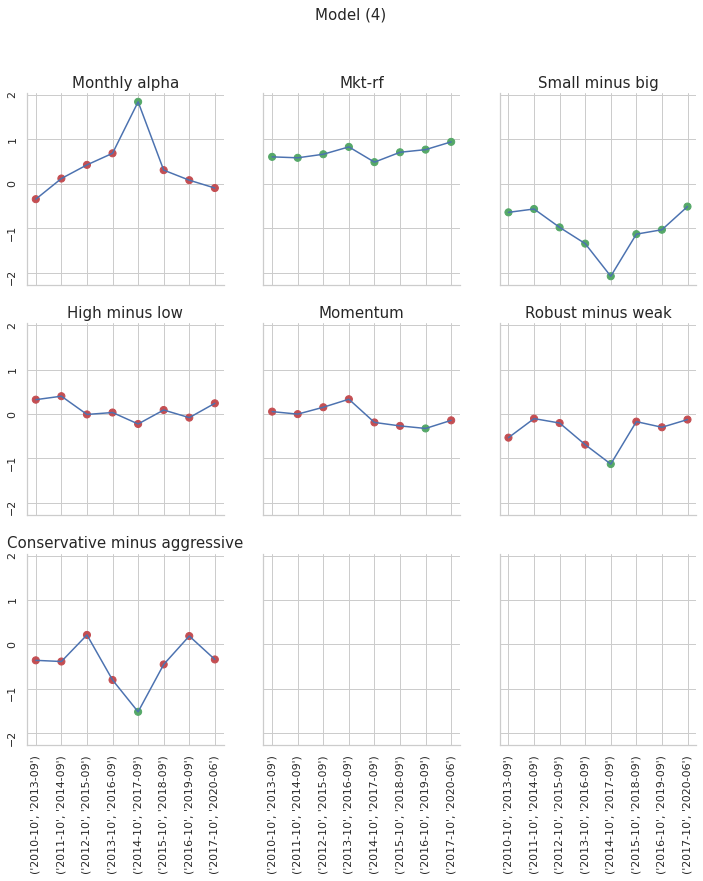

In [ ]:
plot_models(yearly(Factor_Analysis(final_eu).df_rf, 3), "model_4")

### Synthetic Index 

In [ ]:
sns.set_style("whitegrid")
def synthetic_index(df):
  df=df.iloc[32:]
  variables=regression_models(df).params.loc["model_4"][1:].index
  betas=np.array(regression_models(df).params.loc["model_4"][1:])

  df=pd.merge(df, final_eu[["date", "euribor"]], on="date")
  rf=df.euribor
  dates=df.date

  ret_factor=(1 + df.iloc[:,1]/100 + rf/100)
  returns_fund=np.cumprod(ret_factor) -1 

  returns= ((df.loc[:,variables][1:]/100) * betas).sum(axis=1)
  ret_factor_synth= (returns + rf/100) + 1
  returns_synthetic= np.cumprod(ret_factor_synth) - 1

  labels=[]
  i=0
  while i < len(dates):
    if i < len(dates)-11:
      labels.append(dates.iloc[i])
      i+=12
    else:
      labels.append(dates.iloc[-1])
      break
  
  returns_synthetic[0]=0
  returns_fund[0]=0
  plt.figure(figsize=(18,8))
  plt.title("Cumulative returns in %")
  plt.plot(dates, returns_synthetic,
            label="Synthetic", color="#BD582C")
  plt.plot(dates, returns_fund, color="green",
          label="Fund")

  plt.xticks(ticks=labels ,rotation=90)
  plt.legend(fontsize=15)

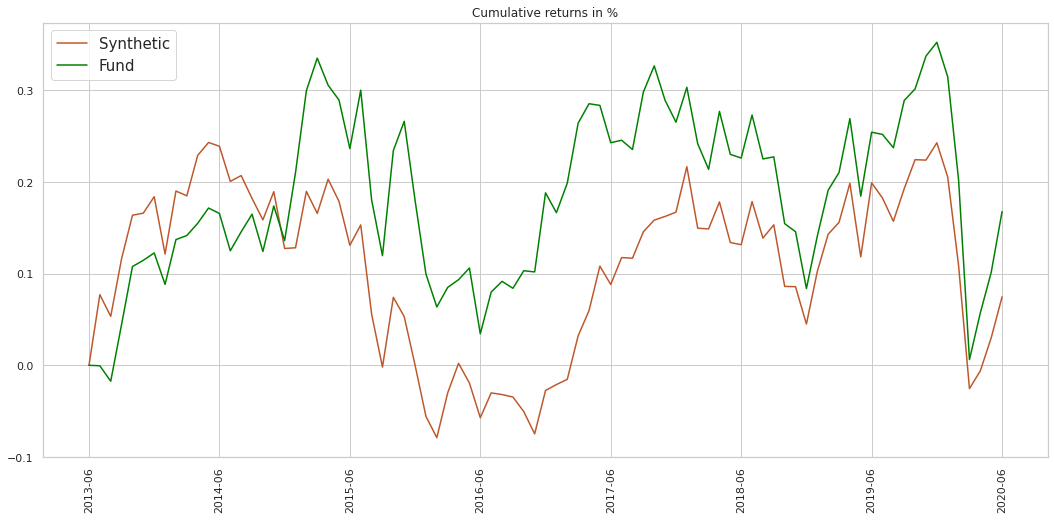

In [ ]:
synthetic_index(Factor_Analysis(final_eu).df_rf)